This work compares different layers for weight perturbation in tensorflow probability.

Weight perturbations: A class of methods which sample the weights of a neural network stochastically at training time. 



## DenseVariational 

Given weights $K, b$, assume
$$K, b \sim Prior(\theta)$$
$$M = q_{\theta}(X) \tag{  distribution for Y}$$
$$Y \sim \text{Likelihood}(M)$$

* Rather than fitting a point estimate for the weights of NNs, Variational Bayesian neural networks put a prior $p(W)$ over the weights and approximate the posterior $p(W|D) \propto p(W)p(D|W)$

* Using surrogate q and maximizing the ELBO, with objective: 

$$ E_{q}[\log p(D|W)] - KL[q||p]$$

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
tfd = tfp.distributions

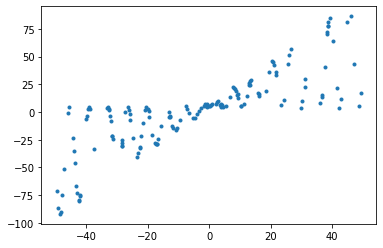

In [2]:
# Generate data

k = 1
b = 5
x_min = -50
x_max = 50
n = 150

def aleatoric(x): # variablity function for a particular x
  r = (x - x_min) / (x_max - x_min)
  return 2 * r

def generate_data(n):
  x = (x_max - x_min) * np.random.rand(n) + x_min 
  x = np.sort(x)
  noise = np.random.randn(n) * aleatoric(x)
  y = (k * x * (1 + np.sin(x)) + b) + noise   # add some non-linearity and noise
  x = x[..., np.newaxis] # convert to N * 1 matrix
  return np.squeeze(x), np.squeeze(y)

x_train, y_train = generate_data(n)
x_test, y_test = generate_data(n)

plt.figure()
plt.plot(x_train, y_train, ".")
plt.show()

In [3]:
def neg_loglike(target, pred_distribution):
  return -pred_distribution.log_prob(target)
def kernel_divergence_fn(q, p, _):
  return tfp.distributions.kl_divergence(q, p) / x_train.shape[0]
def bias_divergence_fn(q, p, _):
  return tfp.distributions.kl_divergence(q, p) / x_train.shape[0]

def output_normal(params):
  return tfp.distributions.Normal(
      # mean and variance learned from the previous layer
      loc=params[:,0:1],
      scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2])
  )

In [4]:
def predict(model):
  predictions = []
  for i in range(50):
    predictions.append(model.predict(x_test))
  predictions = np.array(predictions)
  mu = np.squeeze(np.mean(predictions, axis=0))
  std = np.squeeze(np.std(predictions, axis=0))
  plt.plot(x_test, mu, ".", label = "Mean prediction")
  plt.fill_between(x_test, mu - 2*std, mu + 2*std, alpha = 0.2)
  plt.title("Prediction on test set")
  plt.show()

In [5]:
# Need to specify prior and posterior of the weights
# while DenseReparameterization layer, DenseLocalReparameterization layer, 
# and DenseFlipout layer has default kernel prior/posterior function

# use Full-rank Gaussian approximation here

def prior_fullrank(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  prior_model = tf.keras.Sequential(
      [tfp.layers.DistributionLambda(lambda t: tfp.distributions.MultivariateNormalDiag(
          loc=tf.zeros(n), scale_diag=tf.ones(n)
      ))]
      )
  return prior_model

def posterior_fullrank(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  posterior_model = tf.keras.Sequential(
      [tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
                          # create trainable parameters for MVN with size n
       tfp.layers.MultivariateNormalTriL(n),]
  )
  return posterior_model

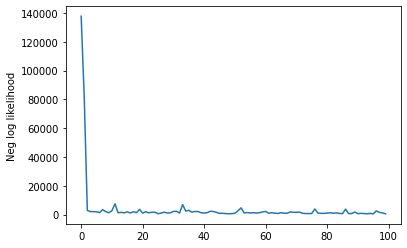

In [6]:
inputs = layers.Input(shape=(1,))
model = tf.keras.Sequential([
                            #  tfp.layers.DenseVariational(32, make_prior_fn=prior_fullrank,
                            #                              make_posterior_fn=posterior_fullrank,
                            #                              kl_weight=1/x_train.shape[0], activation = tf.nn.relu),
                             
                             tfp.layers.DenseVariational(2, make_prior_fn=prior_fullrank,
                                                         make_posterior_fn=posterior_fullrank,
                                                         kl_weight=1/x_train.shape[0]),
                             tfp.layers.DistributionLambda(output_normal),
])
pred_distribution = model(inputs)
model_variational = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
model_variational.compile(tf.keras.optimizers.Adam(learning_rate=0.05), loss=neg_loglike)

history_variational = model_variational.fit(x_train, y_train, epochs=100, verbose=0)
plt.plot(history_variational.history['loss'])
plt.ylabel("Neg log likelihood")
plt.show()

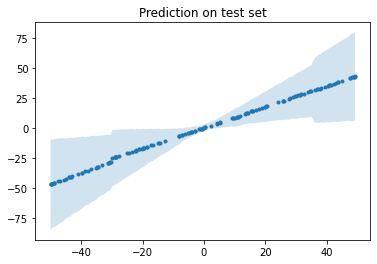

In [7]:
predict(model_variational)

As the model capacity/complexity increases, the uncertainty increases dramatically. 

## DenseReparameterization

$$K, b \sim \text{Posterior}$$
$$ M = \sigma(KX + b) \tag{$\sigma$ is the activation function}$$
* Bayesian variational inference assumes weights $K, b$ are drawn from distributions. 

* Forward pass is stoastic: sampling from posterior

* DenseReparameterization layer uses the [(global) reparameterization trick](https://arxiv.org/abs/1312.6114), which performs a Monte Carlo approximation of the distribution integrating over $K, b$

* Reparameterization trick allows backpropogation to flow through a sampling node by $W_{ij} = \bar{W_{ij}} + σ_{ij}\epsilon_{ij}$, where $ϵ$ is the only stochastic node. This approach is noted as Gaussian pertubations.

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


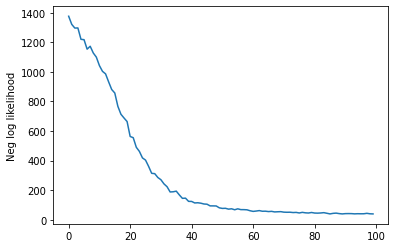

In [8]:
inputs = layers.Input(shape=(1,))
model = tf.keras.Sequential([
                             tfp.layers.DenseReparameterization(32, kernel_divergence_fn=kernel_divergence_fn,
                                                     bias_divergence_fn=bias_divergence_fn, activation = tf.nn.relu),
                             tfp.layers.DenseReparameterization(32, kernel_divergence_fn=kernel_divergence_fn,
                                                     bias_divergence_fn=bias_divergence_fn, activation = tf.nn.relu),
                             tfp.layers.DenseReparameterization(2, kernel_divergence_fn=kernel_divergence_fn,
                                                     bias_divergence_fn=bias_divergence_fn),
                             tfp.layers.DistributionLambda(output_normal),
])
pred_distribution = model(inputs)
model_reparam = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
model_reparam.compile(tf.keras.optimizers.Adam(), loss=neg_loglike)

history_reparam = model_reparam.fit(x_train, y_train, epochs=100, verbose=0)
plt.plot(history_reparam.history['loss'])
plt.ylabel("Neg log likelihood")
plt.show()

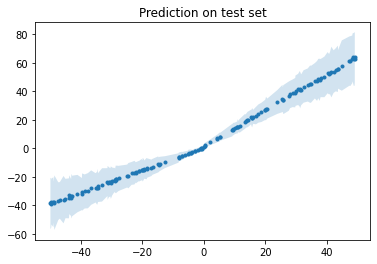

In [9]:
predict(model_reparam)

## DenseLocalParameterization

$$K, b \sim \text{Posterior}$$
$$ M = \sigma(KX + b) \tag{$\sigma$ is the activation function}$$

* For fully connected networks with no weight sharing, unbiased stochastic gradients could be computed without explicit weight perturbations using the local reparameterization trick. 

* LRT samples from the activations $M$ instead of the weights $W$


* DenseLocalParameterization layer uses the [local reparameterization estimator](https://arxiv.org/abs/1506.02557), which performs a Monte Carlo approximation of the hidden units induced by $K, b$


For a Gaussian posterior $q(W_{ij}) = N(\mu_{ij}, \sigma_{ij}^2)$, we have hidden units $q(M_{j}|X) = N(\gamma_{j}, \delta_{j})$,

where $\gamma_{j} = \sum_{i}x_{i}\mu_{i,j}$ and $\delta_j = \sum_{i}x_{i}^2\sigma_{ij}^2$

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


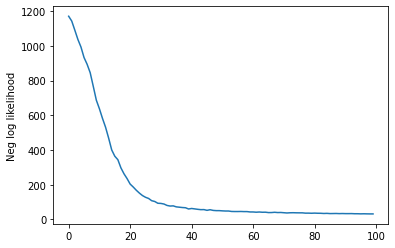

In [10]:
inputs = layers.Input(shape=(1,))
model = tf.keras.Sequential([
                             tfp.layers.DenseLocalReparameterization(32, kernel_divergence_fn=kernel_divergence_fn,
                                                     bias_divergence_fn=bias_divergence_fn, activation = tf.nn.relu),
                             tfp.layers.DenseLocalReparameterization(32, kernel_divergence_fn=kernel_divergence_fn,
                                                     bias_divergence_fn=bias_divergence_fn, activation = tf.nn.relu),
                             tfp.layers.DenseLocalReparameterization(2, kernel_divergence_fn=kernel_divergence_fn,
                                                     bias_divergence_fn=bias_divergence_fn),
                             tfp.layers.DistributionLambda(output_normal),
])
pred_distribution = model(inputs)
model_localreparam = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
model_localreparam.compile(tf.keras.optimizers.Adam(), loss=neg_loglike)

history_localreparam = model_localreparam.fit(x_train, y_train, epochs=100, verbose=0)
plt.plot(history_localreparam.history['loss'])
plt.ylabel("Neg log likelihood")
plt.show()

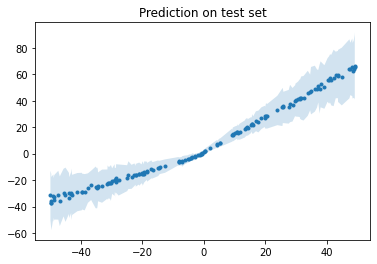

In [11]:
predict(model_localreparam)

## Flipout

$$K, b \sim \text{Posterior}$$
$$ M = \sigma(KX + b) \tag{$\sigma$ is the activation function}$$

* While weight perturbation algorithms suffer from high variance of the gradient estimates because all training examples in a mini-batch share the same perturbation, flipout can decorrelate the gradients between different samples and perturb the weights quasi-independently within a mini-batch. 

* Flipout uses a base perturbation $\Delta W$ shared by all examples in the mini-batch, and multiplies it by a rank-one sign matrix for each example:

$$\Delta W_n = \Delta W \circ r_n s_n^T$$

where $r_n, s_n$ are random vectors whose entries are randomly sampled from $1, -1$. Note that $\Delta W_n = \Delta W \circ E$ is identically distributed to $\Delta W$ when $E$ is a random sign matrix. 


* DenseFlipout layer uses the [Flipout estimator](https://arxiv.org/abs/1803.04386), which performs a Monte Carlo approximation integrating over $K, b$

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


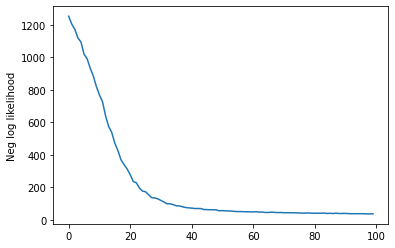

In [12]:
inputs = layers.Input(shape=(1,))
model = tf.keras.Sequential([
                             tfp.layers.DenseFlipout(32, kernel_divergence_fn=kernel_divergence_fn,
                                                     bias_divergence_fn=bias_divergence_fn, activation = tf.nn.relu),
                             tfp.layers.DenseFlipout(32, kernel_divergence_fn=kernel_divergence_fn,
                                                     bias_divergence_fn=bias_divergence_fn, activation = tf.nn.relu),
                             tfp.layers.DenseFlipout(2, kernel_divergence_fn=kernel_divergence_fn,
                                                     bias_divergence_fn=bias_divergence_fn),
                             tfp.layers.DistributionLambda(output_normal),
])
pred_distribution = model(inputs)
model_flipout = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
model_flipout.compile(tf.keras.optimizers.Adam(), loss=neg_loglike)

history_flipout = model_flipout.fit(x_train, y_train, epochs=100, verbose=0)
plt.plot(history_flipout.history['loss'])
plt.ylabel("Neg log likelihood")
plt.show()

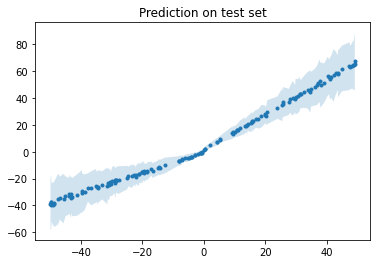

In [13]:
predict(model_flipout)

Comments:

* The results for DenseReparameterization layer, DenseLocalReparameterization layer, and DenseFlipout layer are very similar for the same model architecture. Not sure if this is expected. 